# Homework 3

This Notebook builds on the unit commitment model introduced in [Notebook 5](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks) and the storage model introduced in [Notebook 2](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks).

First, load (or install if necessary) a set of packages you'll need for this assignment...

In [175]:
# Uncomment and run this first line if you need to install or update packages
import Pkg; Pkg.add("JuMP"); Pkg.add("HiGHS"); Pkg.add("DataFrames"); Pkg.add("CSV"); Pkg.add("Plots"); Pkg.add("VegaLite")
using JuMP
using HiGHS
using DataFrames
using CSV
using Plots; plotly();
using VegaLite  # to make some nice plots

#=
Function to convert JuMP outputs (technically, AxisArrays) with two-indexes to a dataframe
Inputs:
    var -- JuMP AxisArray (e.g., value.(GEN))
Reference: https://jump.dev/JuMP.jl/v0.19/containers/
=#
function value_to_df_2dim(var)
    solution = DataFrame(var.data, :auto)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

   Resolving package versions...
  No Changes to `~/Documents/GitHub/power-systems-optimization/Project.toml`
  No Changes to `~/Documents/GitHub/power-systems-optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/power-systems-optimization/Project.toml`
  No Changes to `~/Documents/GitHub/power-systems-optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/power-systems-optimization/Project.toml`
  No Changes to `~/Documents/GitHub/power-systems-optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/power-systems-optimization/Project.toml`
  No Changes to `~/Documents/GitHub/power-systems-optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/power-systems-optimization/Project.toml`
  No Changes to `~/Documents/GitHub/power-systems-optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Document

value_to_df_2dim (generic function with 1 method)

## Question 1 - Compare startup costs in unit commitment

**A. Code and run basic model.**

Data for this problem is stored in [`Homeworks/hw3_data`](hw3_data/).

Following the `unit_commitment_simple` modeling formulation in [Notebook 5](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks), load the above data and create a unit commitment solver function with the following set of constraints:

- Demand balance
- Minimum / maximum generator constraints (non-committed)
- Minimum / maximum generator constraints (committed)
- Three-variable commitment formulation

Note: the data (with hours 1-24) is already in local time. Hence, do not convert from GMT to GMT-8.

Run the UC for the given day and plot a stacked area chart of generation using `@vlplot` from the `VegaLite` package.

Throughout this assignment, please use a relative MIP gap of 1% for all questions. (If you are having difficulty getting this to solve on your computer in a reasonble amount of time, you can relax the gap but please then specify clearly in your comments that you have done so.)

In [176]:
# load data
datadir = joinpath("hw3_data")
gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Demand.csv"), DataFrame);
gen_variable = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);

# Unit commitment notebook suggests renaming all columns to lowercase:
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end

In [177]:
# Construct the generator dataframe - using the code from Notebook 5

# Keep columns relevant to our UC model 
select!(gen_info, 1:26) # columns 1:26
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0 # if the cost is missing (i.e. renewables), give it zero instead

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false # start by setting everything to not variable
gen_df[in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(gen_df.resource),
    :is_variable] .= true; # switch flag to "true" for all variable sources (wind, small hydro, solar)

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:]

Row,r_id,resource,region,existing_cap_mw,num_units,cap_size,var_om_cost_per_mwh,var_om_cost_per_mwh_in,fuel,heat_rate_mmbtu_per_mwh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,min_power,ramp_up_percentage,ramp_dn_percentage,start_cost_per_mw,start_fuel_mmbtu_per_mw,up_time,down_time,self_disch,eff_up,eff_down,ratio_power_to_energy,min_duration,max_duration,cluster,fuel_cost,co2_content_tons_per_mmbtu,is_variable,gen_full
,Int64?,String?,String15?,Float64?,Int64?,Float64?,Float64?,Int64?,String31,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Bool,String
1,1,biomass,WEC_SDGE,21.4,20,1.07,5.234,0,None,12.76,1.471,4.147,0.71,1.0,1.0,0,0.0,0,0,0,1.0,1.0,1.0,0,0,1,0.0,0.0,false,wec_sdge_biomass_1.0
2,2,hydroelectric_pumped_storage,WEC_SDGE,100.0,2,21.0,0.0,0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0,0,0,0.866,0.866,0.25,0,0,1,0.0,0.0,false,wec_sdge_hydroelectric_pumped_storage_1.0
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,600.0,1,607.1,3.4,0,pacific_naturalgas,7.52,0.0,0.0,0.362,0.4,0.4,87,2.0,6,6,0,1.0,1.0,1.0,0,0,1,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_1.0
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,500.0,1,570.0,3.4,0,pacific_naturalgas,7.15,0.0,0.0,0.351,0.4,0.4,87,2.0,6,6,0,1.0,1.0,1.0,0,0,2,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_2.0
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,336.0,3,112.0,10.8,0,pacific_naturalgas,10.03,0.0,0.0,0.446,3.78,3.78,113,3.5,6,6,0,1.0,1.0,1.0,0,0,3,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_3.0
6,6,natural_gas_fired_combustion_turbine,WEC_SDGE,91.6,2,45.8,10.8,0,pacific_naturalgas,10.69,0.0,0.0,0.8,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,1,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_1.0
7,7,natural_gas_fired_combustion_turbine,WEC_SDGE,49.9,1,49.9,10.8,0,pacific_naturalgas,10.48,0.0,0.0,0.487,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,2,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_2.0
8,8,natural_gas_fired_combustion_turbine,WEC_SDGE,48.1,1,48.1,10.8,0,pacific_naturalgas,11.04,0.0,0.0,0.437,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,3,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_3.0
9,9,natural_gas_fired_combustion_turbine,WEC_SDGE,34.6,1,34.6,10.8,0,pacific_naturalgas,16.86,0.0,0.0,0.954,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,4,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_4.0


In [178]:
# Per Notebook 5, convert to "long" format
gen_variable_long = stack(gen_variable, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);

In [179]:
# create function to solve simple unit commitment problem

#= Arguments/inputs to function:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
    mip_gap -- desired relative MIP gap to pass to solver
=#

function unit_commitment_simple(gen_df, loads, gen_variable, mip_gap)
    UC = Model(HiGHS.Optimizer) 
    set_optimizer_attribute(UC, "mip_rel_gap", mip_gap) # modifying default parameters for solver itself (in this case, setting relative/percentage gap)

    # Define sets based on data
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources for which unit commitment constraints do NOT apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Non-variable and non-thermal resources
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal) # pumped hydro storage 
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one (to avoid indexing problems later)

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(UC, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
    end)
                
    # Objective function
        # Sum of variable costs + start-up costs for all generators and time periods
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + # thermal resources variable cost includes fuel + O&M 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + # renewables variable cost includes only O&M, no fuel
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T) # only thermal resources have start up cost
    )
    
    # Demand balance constraint (supply must = demand in all time periods)
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
      # 3. variable generation, accounting for hourly capacity factor
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Solve statement 
    optimize!(UC)

    # Generation solution and convert to data frame using value_to_df_2dim function
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution parameters and objective
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(UC),
        status = termination_status(UC)
    )

end

unit_commitment_simple (generic function with 1 method)

In [180]:
# Use simple unit commitment function from previous cell to solve for given day with MIP gap = 1%
UC_solution = unit_commitment_simple(gen_df, loads, gen_variable_long, 0.01)

Presolving model
2013 rows, 1707 cols, 6595 nonzeros
1791 rows, 1423 cols, 7349 nonzeros

Solving MIP model with:
   1791 rows
   1423 cols (968 binary, 0 integer, 0 implied int., 455 continuous)
   7349 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   473023.409268   inf                  inf        0      0     14       504     0.0s
 R       0       0         0   0.00%   473109.528604   484073.243791      2.26%      112     14     28       528     0.1s
 C       0       0         0   0.00%   473109.528604   473965.776921      0.18%      112     14     28       5

(gen = 528×3 DataFrame
 Row │ r_id    hour   gen     
     │ Int64?  Int64  Float64 
─────┼────────────────────────
   1 │      1      1   21.4
   2 │      2      1  100.0
   3 │      3      1  256.487
   4 │      4      1  500.0
   5 │      5      1    0.0
   6 │      6      1    0.0
   7 │      7      1    0.0
   8 │      8      1    0.0
   9 │      9      1    0.0
  10 │     10      1    0.0
  11 │     11      1    0.0
  ⋮  │   ⋮       ⋮       ⋮
 519 │     13     24    0.0
 520 │     14     24    0.0
 521 │     15     24    0.0
 522 │     16     24    0.0
 523 │     17     24    0.0
 524 │     18     24    0.0
 525 │     19     24    0.0
 526 │     20     24  134.28
 527 │     21     24   21.755
 528 │     22     24    0.0
              507 rows omitted, commit = 408×3 DataFrame
 Row │ r_id    hour   gen     
     │ Int64?  Int64  Float64 
─────┼────────────────────────
   1 │      3      1      1.0
   2 │      4      1      1.0
   3 │      5      1      0.0
   4 │      6      1    

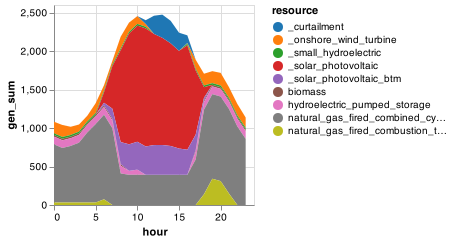

In [192]:
# Plot stacked area chart of generation for the given day using vegalite

# Add in BTM solar and curtailment and plot results

# need to define T_period to use the code from Notebook 5
T_period = 1:24

sol_gen = innerjoin(UC_solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_long[gen_variable_long.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(UC_solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

**B. Zero startup costs sensitivity**

Next, create a modified version of the generator dataframe (`gen_df_sens = copy(gen_df)`) and set the startup costs for all generators to be 0.

Rerun the UC and compare with the first solution. What are the main differences and why?

In [193]:
# set start-up costs for all generators to be 0
gen_df_sens = copy(gen_df)
gen_df_sens.start_cost_per_mw .= 0;

In [194]:
# find new solution for zero start up cost scenario
UC_no_startup_sol = unit_commitment_simple(gen_df_sens, loads, gen_variable_long, 0.01)

Presolving model
2013 rows, 1707 cols, 6595 nonzeros
1791 rows, 1423 cols, 7349 nonzeros

Solving MIP model with:
   1791 rows
   1423 cols (968 binary, 0 integer, 0 implied int., 455 continuous)
   7349 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   391175.854994   inf                  inf        0      0     13       272     0.0s
 C       0       0         0   0.00%   394309.521925   500327.056643     21.19%      535     47    119       569     0.1s
 L       0       0         0   0.00%   394838.169361   395637.968622      0.20%     2763    146    119      12

(gen = 528×3 DataFrame
 Row │ r_id    hour   gen     
     │ Int64?  Int64  Float64 
─────┼────────────────────────
   1 │      1      1   21.4
   2 │      2      1  100.0
   3 │      3      1  288.795
   4 │      4      1  500.0
   5 │      5      1    0.0
   6 │      6      1    0.0
   7 │      7      1    0.0
   8 │      8      1    0.0
   9 │      9      1    0.0
  10 │     10      1    0.0
  11 │     11      1    0.0
  ⋮  │   ⋮       ⋮       ⋮
 519 │     13     24    0.0
 520 │     14     24    0.0
 521 │     15     24    0.0
 522 │     16     24    0.0
 523 │     17     24    0.0
 524 │     18     24    0.0
 525 │     19     24    0.0
 526 │     20     24  134.28
 527 │     21     24   21.755
 528 │     22     24    0.0
              507 rows omitted, commit = 408×3 DataFrame
 Row │ r_id    hour   gen          
     │ Int64?  Int64  Float64      
─────┼─────────────────────────────
   1 │      3      1   1.0
   2 │      4      1   1.0
   3 │      5      1   0.0
   4 │      6     

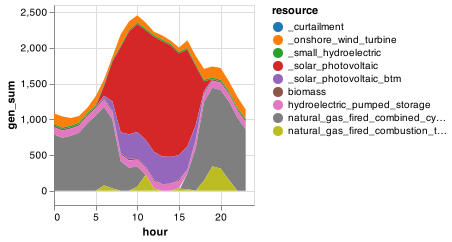

In [195]:
# Plot stacked area chart of generation for the given day using vegalite

# Add in BTM solar and curtailment and plot results

# need to define T_period to use the code from Notebook 5
T_period = 1:24

sol_gen_zero = innerjoin(UC_no_startup_sol.gen, 
                    gen_df_sens[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_zero = combine(groupby(sol_gen_zero, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen_zero[sol_gen_zero.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_zero[sol_gen_zero.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_zero[sol_gen_zero.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_long[gen_variable_long.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_zero, btm)

# Curtailment
curtail = combine(groupby(UC_no_startup_sol.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen_zero, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen_zero.hour = sol_gen_zero.hour .- T_period[1]

sol_gen_zero |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

The solution with no startup costs has a lower overall cost as its optimal solution. This makes sense because there are fewer constraints and starting up a new generator incurs no additional costs as start up does do in the example with non-zero startup costs. Additionally, the solution with no startup costs has no curtailment. This is because when there are startup costs, it can be less expensive to leave certain generators running rather than turning them off and then later turning them on again (i.e. the fuel costs for continued use are lower than the alternative cost of starting it up for a second time). In this case, curtailment of renewables would be necessary to allow these generators to remain on. However, in a scenario without any startup costs, generators can be turned on and off without incurring additional costs, meaning that renewables always generate when possible and nonrenewables are brought online to meet demand in all other cases such that no curtailment is necessary (i.e., only turn it on when it is needed).

## Question 2: Implement pumped hydropower storage

In the data, we have a generator `hydroelectric_pumped_storage` which is a pumped hydro storage (PHS) facility. We have been treating it as a free resource, but in fact, it's a battery. 

The PHS equations for stored water are identical to the state of charge for the battery in Notebook 2:

\begin{align*} 
SOC_t = SOC_{t-1} + \big(CHARGE_t * battery\_eff - \frac{DISCHARGE_t}{battery\_eff}\big)  \quad \forall t \in T
\end{align*}

In addition, the PHS has a power capacity constraint given in the dataframe's `existing_cap_mw` variable. You will also need to implement an energy capacity constraint. 

**A. Code pumped hydropower storage constraints.**

Copy the `unit_commitment_simple` code above into a new cell below and rename the function `unit_commitment_storage`.

Reviewing [Notebook 2](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks), add in relevant constraints for charging and discharging pumped hydropower. Assume the following parameters:

- One-way efficiency is $battery_{eff} = 0.84$ (i.e., round-trip efficiency = $0.7$)
- Energy capacity = 4 x Power capacity
- Stored energy starts and ends the day at 50% capacity (you will need to code these constraints)

Indicate which equations and variables you have added and explain your steps using inline code comments (e.g. `# Comment`).

In [185]:
#= Changes to simple unit commitment to incorporate pumped hydrostorage include:
    - adding the parameters batt_eff, batt_start_charge, and batt_end_charge to the function
    - changing sets to include one for just pumped hydro and one for any other non-variable, non-thermal
    - include definitions for battery capacity and energy capacity of battery
    - adding three decision variables: SOC (state iof charge), CHARGE, DISCHARGE; all indexed across T
    - update demand balance constraint: for the total system, demand can now be met through the standard 
      generation (as in simple version above) or via the discharge from the battery. Also, the demand/load needs
      to include the loading
    - separate constraint #2 (nonvariable generation not requiring commitment) into two sections: one for 
      biomass and one for pumped hydro
    - for pumped hydro constraints, add the following:
        - SOC constraint for first period using start charge instead of SOC[t-1]
        - SOC constraint for all other time periods using eqn from Notebook 2
        - SOC constraint for final period where SOC_last_time = batt_end_charge
    - calculate and include values for state of charge, charge, and discharge to the info the function returns
=#

#= Arguments/inputs to function:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
    mip_gap -- desired relative MIP gap to pass to solver
    batt_eff -- battery efficiency; given here as 0.84 for the pumped hydropower 
    batt_start_charge -- starting charge of the battery for the day (given here as 50% capacity)
    batt_end_charge -- ending charge of the battery for the day (given here as 50% capacity)
=#

function unit_commitment_storage(gen_df, loads, gen_variable, mip_gap, batt_eff, batt_start_charge, batt_end_charge)
    UC = Model(HiGHS.Optimizer) 
    set_optimizer_attribute(UC, "mip_rel_gap", mip_gap)

    # Define sets based on data
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources for which unit commitment constraints do NOT apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Pumped hydro storage only
    G_pumped_hydro = gen_df[gen_df[!,:resource] .== "hydroelectric_pumped_storage", :r_id]
            # Non-variable and non-thermal resources (including hydro)
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal) 
            # Non-variable and non-thermal resources (not including hydro - only biomass)
    G_nt_nonvar_no_hydro = setdiff(G_nt_nonvar, G_pumped_hydro) 
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one (to avoid indexing problems later)

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
    
    # energy capacity for pumped hydro battery (4*power capactiy)
    batt_cap = gen_df[gen_df.r_id .== G_pumped_hydro,:existing_cap_mw][1]
    energy_cap_batt = 4 * batt_cap
    
    # Decision variables   
    @variables(UC, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
        energy_cap_batt >= SOC[T] >= 0 # state of charge of battery between 0 and energy cap (4*power cap)
        batt_cap >= CHARGE[T] >= 0 # how much power to charge the pumped hydro battery
        batt_cap >= DISCHARGE[T] >= 0 # how  much power to discharge from the pumped hydro battery
    end)
                
    # Objective function
        # Sum of variable costs + start-up costs for all generators and time periods
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + # thermal resources variable cost includes fuel + O&M 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + # renewables variable cost includes only O&M, no fuel
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T) # only thermal resources have start up cost
    )
        
    # Demand balance constraint (supply must = demand in all time periods)
    # supply now also includes discharge from hydro pumped storage battery and demand includes the charging
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) + DISCHARGE[t] == loads[loads.hour .== t,:demand][1] + CHARGE[t])

    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment - biomass
    @constraint(UC, Cap_nt_nonvar_not_hydro[i in G_nt_nonvar_no_hydro, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

      # 3. non-variable generation not requiring commitment - pumped hydro storage
    @constraint(UC, Cap_nt_nonvar_pumpedhydro[G_pumped_hydro, t in T],
        GEN[2,t] <= gen_df[gen_df.r_id .== 1,:existing_cap_mw][1])
        
        # Pumped storage state of charge constraints:
        # First period state of charge:
    @constraint(UC, SOC_first[[1]],
        SOC[1] == batt_start_charge + (CHARGE[1]*batt_eff - DISCHARGE[1]/batt_eff))
        # All other hours:
    @constraint(UC, SOC_middle[t in T[T .>1]], 
        SOC[t] == SOC[t-1] + CHARGE[t]*batt_eff - DISCHARGE[t]/batt_eff)
        # Final hour:
    @constraint(UC, SOC_nt_nonvar_last[[last(T)]], 
        SOC[last(T)] == batt_end_charge)
    
    
      # 4. variable generation, accounting for hourly capacity factor
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Solve statement 
    optimize!(UC)

    # Generation solution and convert to data frame using value_to_df_2dim function
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # PHS charge 
    charge = value.(CHARGE).data
    
    # PHS discharge
    discharge = value.(DISCHARGE).data
    
    # PHS state of charge
    soc = value.(SOC).data
    
    # Return the solution parameters and objective
    return (
        gen,
        commit,
        curtail,
        charge, # return charge for plotting
        discharge, # return discharge for plotting
        soc, # return state of charge of battery for plotting
        cost = objective_value(UC),
        status = termination_status(UC)
    )

end

unit_commitment_storage (generic function with 1 method)

**B. Solve the new UC with PHS and plot.**

Using the above formulation, solve for the same parameters in Problem 1 and plot. For the purposes of plotting, you will want to create two resources&mdash;PHS_charge and PHS_discharge. By convention, you could put PHS_charge on top to indicate this is increasing system load.

In [186]:
# Use simple unit commitment function from previous cell to solve for given day with MIP gap = 1%
batt_eff = 0.84
batt_cap = 4 * gen_df[gen_df.r_id .== 2,:existing_cap_mw][1]
batt_start = 0.5 * batt_cap
batt_end = 0.5 * batt_cap
UC_solution_batt = unit_commitment_storage(gen_df, loads, gen_variable_long, 0.01, batt_eff, batt_start, batt_end)

Presolving model
2037 rows, 1778 cols, 6737 nonzeros
1812 rows, 1492 cols, 7508 nonzeros

Solving MIP model with:
   1812 rows
   1492 cols (967 binary, 0 integer, 0 implied int., 525 continuous)
   7508 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   492624.93758    inf                  inf        0      0     11       529     0.0s
 C       0       0         0   0.00%   493407.078477   569327.630912     13.34%      834     28    161       634     0.1s
 L       0       0         0   0.00%   494039.590276   496029.314228      0.40%     4631     58    161      11

(gen = 528×3 DataFrame
 Row │ r_id    hour   gen     
     │ Int64?  Int64  Float64 
─────┼────────────────────────
   1 │      1      1   21.4
   2 │      2      1   21.4
   3 │      3      1  335.087
   4 │      4      1  500.0
   5 │      5      1    0.0
   6 │      6      1    0.0
   7 │      7      1    0.0
   8 │      8      1    0.0
   9 │      9      1    0.0
  10 │     10      1    0.0
  11 │     11      1   -0.0
  ⋮  │   ⋮       ⋮       ⋮
 519 │     13     24    0.0
 520 │     14     24    0.0
 521 │     15     24    0.0
 522 │     16     24    0.0
 523 │     17     24    0.0
 524 │     18     24    0.0
 525 │     19     24    0.0
 526 │     20     24  134.28
 527 │     21     24   21.755
 528 │     22     24    0.0
              507 rows omitted, commit = 408×3 DataFrame
 Row │ r_id    hour   gen     
     │ Int64?  Int64  Float64 
─────┼────────────────────────
   1 │      3      1      1.0
   2 │      4      1      1.0
   3 │      5      1      0.0
   4 │      6      1    

In [187]:
# Line plot of battery charge, discharge, and state of charge over time 
soc = UC_solution_batt.soc
charge = UC_solution_batt.charge
discharge = UC_solution_batt.discharge

plot(soc, label = "State of charge (MWh)")
plot!(charge, label="Charge (MW)")
plot!(discharge, label = "Discharge (MW)")


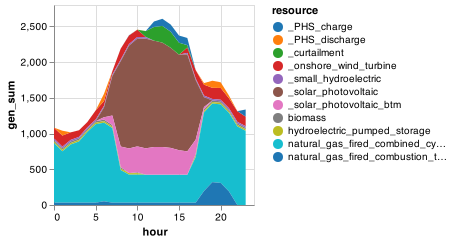

In [196]:
# Plot stacked area chart of generation for the given day using vegalite

# Add in BTM solar and curtailment and plot results

# need to define T_period to use the code from Notebook 5
T_period = 1:24

sol_gen_batt = innerjoin(UC_solution_batt.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_batt = combine(groupby(sol_gen_batt, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen_batt[sol_gen_batt.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_batt[sol_gen_batt.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_batt[sol_gen_batt.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_long[gen_variable_long.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_batt, btm)

# Curtailment
curtail = combine(groupby(UC_solution_batt.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen_batt, curtail[:,[:resource, :hour, :gen_sum]])

# PHS Charge
PHS_charge = DataFrame(hour = T_period, charge = UC_solution_batt.charge)
PHS_charge[!, :resource] .= "_PHS_charge"
rename!(PHS_charge, :charge => :gen_sum)
append!(sol_gen_batt, PHS_charge[:,[:resource,:hour,:gen_sum]])

# PHS Discharge
PHS_discharge = DataFrame(hour = T_period, discharge = UC_solution_batt.discharge)
PHS_discharge[!, :resource] .= "_PHS_discharge"
rename!(PHS_discharge, :discharge => :gen_sum)
append!(sol_gen_batt, PHS_discharge[:,[:resource,:hour,:gen_sum]])

# Rescale hours
sol_gen_batt.hour = sol_gen_batt.hour .- T_period[1]

sol_gen_batt |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})


In [197]:
@show(sum(sol_gen[193:216,:gen_sum]));
@show(sum(sol_gen_batt[193:216,:gen_sum]));

sum(sol_gen[193:216, :gen_sum]) = 1213.6799999999998
sum(sol_gen_batt[193:216, :gen_sum]) = 931.3363238095241


In [198]:
plot(sol_gen[193:216,:gen_sum], label="Curtailment without Battery")
plot!(sol_gen_batt[193:216,:gen_sum], label="Curtailment with Battery")

**C. Interpret results**

Answer with a few sentences each of the following:

1. Compare your results to `unit_commitment_simple`. Have any commitments changed?

2. Interpret what is happening with the PHS facility during the day in terms of charging and discharging.

3. Has curtailment reduced? (Explain this in the context of the PHS operation.)

1. The commitments have changed. For example, there is more solar photovoltaic during the middle hours of the day. Also, the sharp spikes in the natural gas generators in the simple unit commitment have been rounded in the version with the battery.

2. The PHS facility charges the battery during periods when the wind and solar are providing a lot of power and would otherwise be curtailed and during times of low demand (in hour 23/24 for example) near the end of the day to return to the 50% capacity at day's end. Discharging occurs when there is higher demand and not as much power being provided by wind/solar (for example hours 18-22) and some early in the day when as total demand is increasing. 

3. Curtailment has decreased from about 1213 MW to about 931 MW when the battery is added. This intuitively makes sense because having the additional battery storage would mean needing either the same or fewer of the non-solar/wind generators remaining on to avoid start up costs, which would decrease curtailment (less "extra" power is being generated). When power is not required from the PHS plant and is being provided instead by wind/solar (rather than curtailed), the otherwise unused power from PHS can instead put that generation towards charging up the battery. 